In [5]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import random
from mpmath import mp
import time 
import copy 
import csv
from tqdm import tqdm 

In [6]:
def calculate_v_values(Q_values_action1, Q_values_action2):
    V_values = np.zeros((2,10))
    for i in range(2):
        for j in range(10):
            V_values[i][j] = max(Q_values_action1[i][j],Q_values_action2[i][j])  # Use keepdims=True to maintain the 2D shape
    return V_values

V_true = np.array([[ 0,         0,          0,          0,          0,          0,
   0,          0,          0,          0        ],
   [5.20609088, 10.98257709, 16.18277733, 21.10806607, 26.14558744, 30.49934127,
  36.64971727, 41.42251637, 45.25001465, 50.77376517]])
# V_true = [9, 8.15241315, 7.47595723, 6.90163656, 6.49113047]

def bellman_relative_error(V_approx, V_true):
    nonzero_indices = V_true != 0
    if np.any(nonzero_indices):
        #relative_errors = np.abs((V_approx[nonzero_indices] - V_true[nonzero_indices]) / V_true[nonzero_indices])
        relative_errors = np.abs((V_approx[nonzero_indices] - V_true[nonzero_indices]))
        return np.mean(relative_errors)
    else:
        return np.nan

In [7]:
def get_prob(step,p1):
    pi = [0]*step
    for i in range(1,step):
        pi[i]=(1-(1-p1)*((lamda)**(1/i)))
    mul = pi[step-1]
    return mul 

class envir():
    def __init__(self):
        self.phi = 9
        self.p1=[]
        for i in range(10):
            self.p1.append(0.05*(i+1))
    def step(self,s,task):
            next_state = copy.copy(s)
            if s[task] == 0:
                next_state[task] = 0
            else:
                #print(s,task,get_prob(s[task],self.p1[task],self.lamda))
                next_state[task] = random.choice([0,s[task]],1,p=[self.p1[task],1-self.p1[task]])
            if s[task]!=0 and next_state[task] == 0:
                reward = 1
            elif s[task]==0:
                reward = -10000
            else:
                reward = 0
            return next_state,reward
            

In [8]:
class Agent():
    def __init__(self,alpha,T,gamma):
        self.Q_values = np.zeros((2,2,2,10))
        self.phi = 9
        self.alpha = alpha
        self.T = T
        self.gamma = gamma
    def activate_task(self,s):
        num = []
        summ = 0
        prob = []
        for i in range(10):
            num.append(mp.exp((self.Q_values[s[i]][0][s[i]][i])/self.T))
            summ = summ + mp.exp((self.Q_values[s[i]][0][s[i]][i])/self.T)
        for i in range(10):
            prob.append(num[i]/summ)
        task = random.choice(10,1,p=prob)
        return task[0]
    
    def activate_task_eps_greedy(self,s,epsilon):
        r = random.random()
        if r < epsilon:
            action = np.random.choice(10)
        else:
            gre = [0]*len(s)
            for i in range(len(s)):
                gre[i] = self.Q_values[s[i]][0][s[i]][i]
            action = np.argmax(gre)
        return action
    
    def check_best_action(self,state):
        ind = 0
        for i,_ in reversed(list(enumerate(state))):
            if state[i] == 1:
                ind = i
                break
        return ind
    
    def act_greedy(self,s,restart_prob,task):
        return max((self.Q_values[s[task]][0][restart_prob][task]),(self.Q_values[s[task]][1][restart_prob][task]))
    
    def update(self,s,task,next_state,reward):
        for k in range(2):
            self.Q_values[s[task]][0][k][task] = (1-self.alpha)*(self.Q_values[s[task]][0][k][task]) + self.alpha*(reward+self.gamma*(self.act_greedy(next_state,k,task)))
            self.Q_values[k][1][s[task]][task] = (1-self.alpha)*(self.Q_values[k][1][s[task]][task]) + self.alpha*(reward+self.gamma*(self.act_greedy(next_state,s[task],task)))

  0%|          | 0/2500 [00:00<?, ?it/s]

C:\Users\Harshit\AppData\Local\Temp\ipykernel_30836\2895790446.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_state[task] = random.choice([0,s[task]],1,p=[self.p1[task],1-self.p1[task]])
100%|██████████| 2500/2500 [12:28<00:00,  3.34it/s]


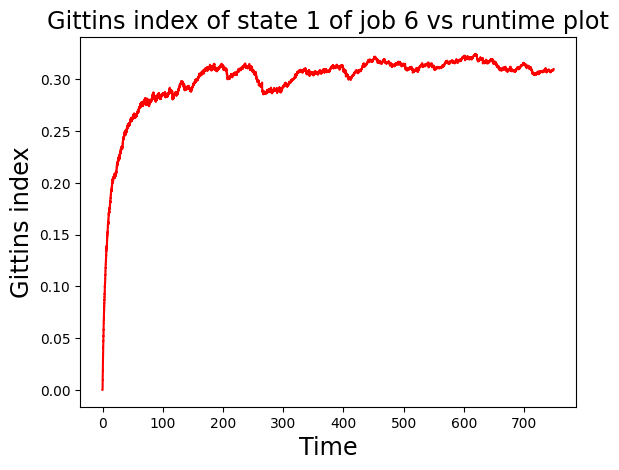

In [ ]:
class pull():
        start_time = time.time()
        env = envir()
        hist01 = []
        t = []
        BRE = []
        agent = Agent(alpha=0.1,T=1000,gamma=0.99)
        episode = 2500
        agent.alpha = 0.1
        agent.gamma = 0.99
        agent.T = 750000
        Tmax = 750000
        Tmin = 0.25
        s = np.array([1,1,1,1,1,1,1,1,1,1])
        phi = 3
        cumm_rew = []
        plt_wrong_actions = []
        eps = 1
        cumm_wrong_steps = []
        for ep_no in tqdm(range(episode)):
            s = np.array([1,1,1,1,1,1,1,1,1,1])
            episode_rew = 0 
            eps = eps*0.9985
            while (s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0 or s[4]!=0 or s[5]!=0 or s[6]!=0 or s[7]!=0 or s[8]!=0 or s[9]!=0):
                #print(s)
                task = agent.activate_task(s)
                if len(cumm_rew)==0:
                    cumm_rew.append(episode_rew)
                else:
                    cumm_rew.append(cumm_rew[-1]+episode_rew)
                task_eps = agent.activate_task_eps_greedy(s,eps)
                task = task_eps
                task_opt = agent.check_best_action(s)
                if task_eps != task_opt:
                    cumm_wrong_steps.append(1)
                else:
                    cumm_wrong_steps.append(0)
                plt_wrong_actions.append(np.mean(cumm_wrong_steps)*100)
                Q0 = np.zeros((2,10))
                M = np.zeros((2,10))
                for i in range(2):
                    for j in range(10):
                        Q0[i][j] = agent.Q_values[i][0][i][j]
                        M[i][j] = agent.Q_values[i][1][i][j]
                V_values = calculate_v_values(Q0,M)
                BRE.append(bellman_relative_error(V_values,V_true))
                #print(task)
                current_time = time.time()-start_time
                next_state,reward = env.step(s,task)
                episode_rew+=reward
                #print(next_state)
                #print('r',reward)
                agent.update(s,task,next_state,reward)
                t.append(current_time)
                if((ep_no%100)==0):
                    agent.alpha = agent.alpha-0.000002
                s = copy.copy(next_state)
                hist01.append(0.01*agent.Q_values[1][0][1][5])
        plt.title('Gittins index of state 1 of job 6 vs runtime plot',fontsize='xx-large')
        plt.xlabel('Time', fontsize = 'xx-large')
        plt.ylabel('Gittins index',fontsize = 'xx-large')
        plt.plot(t,hist01,'-',c='red')
        plt.show()

        filename = 'C:\\Intern\\percent_wrong_restart_constHR.csv'

        # Writing to CSV file
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['percent_wrong'])  # Writing the header
            for value in plt_wrong_actions:
                writer.writerow([value])  # Writing each value in a new row

        filename = 'C:\\Intern\\BRE_restart_constHR.csv'

        # Writing to CSV file
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['BRE'])  # Writing the header
            for value in BRE:
                writer.writerow([value])  # Writing each value in a new row

        filename = 'C:\\Intern\\cumm_rew_restart_constHR.csv'

        # Writing to CSV file
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['cumm_rew'])  # Writing the header
            for value in cumm_rew:
                writer.writerow([value])  # Writing each value in a new row     
